# Clasificación No Balanceada en Inversiones Startups (Crunchbase)

Este trabajo aborda un problema de **clasificación binaria no balanceada** a partir de un dataset abierto de inversiones en startups, disponible en [Kaggle - Startup Investments Crunchbase](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

## Descripción del Proyecto

Este proyecto se desarrolla para la asignatura de **Minería de Datos**, como parte del trabajo final grupal. El objetivo es aplicar técnicas de análisis y modelado sobre un conjunto de datos reales para abordar un problema de clasificación desequilibrada.

A partir del dataset original, se ha redefinido el problema como una clasificación binaria no balanceada. Por ejemplo, se puede predecir si una startup ha recibido financiación por encima de un determinado umbral, o si pertenece a un grupo de industrias consideradas “de alto crecimiento”.

## Objetivos

1. **Formulación del problema** como tarea de clasificación binaria no balanceada.
2. **Análisis exploratorio** de las variables del dataset.
3. **Preparación de los datos**, incluyendo tratamiento de valores perdidos, normalización, codificación y detección de outliers.
4. Aplicación de **técnicas de aprendizaje supervisado**:
   - **K-Nearest Neighbors (KNN)**
   - **Árboles de Decisión**
5. Evaluación mediante **métricas adecuadas** para clasificación no balanceada (como *F1-Score*, *balanced accuracy*, *AUC*, etc.) y **validación cruzada**.
6. Uso de **pipelines y transformadores** para automatizar el preprocesamiento.
7. Aplicación de técnicas de **muestreo (undersampling/oversampling)** y **ajuste de umbrales**.
8. Estudio de la **interpretabilidad del modelo final**.

## Estructura del Notebook

Este notebook está estructurado en las siguientes secciones:

- [1. Carga y descripción del dataset](#)
- [2. Análisis exploratorio de los datos (EDA)](#)
- [3. Formulación del problema de clasificación binaria no balanceada](#)
- [4. Preprocesamiento de datos](#)
- [5. Construcción del pipeline con KNN](#)
- [6. Evaluación del modelo y análisis de resultados](#)
- [7. Árboles de decisión y comparación](#)
- [8. Interpretabilidad del modelo final](#)
- [9. Conclusiones](#)

## 1. Elección del problema

El problema elegido se basa en el dataset **Startup Investments - Crunchbase**, disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo es construir un modelo de **clasificación binaria no balanceada** que permita **predecir si una startup será adquirida** o no. Para ello, hemos definido la variable objetivo `target` de la siguiente forma:

- `target = 1` si la columna `status` es `"acquired"`
- `target = 0` en cualquier otro caso (por ejemplo: `closed`, `ipo`, `operating`, etc.)

Este planteamiento genera un claro desbalance entre clases, ya que el número de startups adquiridas es mucho menor que el resto.

Comenzamos leyendo el dataset original sobre inversiones en startups, proporcionado por Crunchbase y disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo en esta fase inicial es familiarizarnos con la estructura de los datos: número de ejemplos, variables disponibles, tipos de datos y primeras observaciones. Esto nos permitirá definir correctamente el problema de clasificación binaria no balanceada.

El archivo utilizado se llama `investments_VC.csv` y se encuentra en la carpeta `data/`.

In [2]:
import pandas as pd

ruta_datos = "data/investments_VC.csv"

df = pd.read_csv(ruta_datos, encoding="latin1")

print("Dimensiones del dataset: ", df.shape)
df.head()

Dimensiones del dataset:  (54294, 39)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Métrica de rendimiento y validación

Dado que se trata de un problema de **clasificación no balanceada**, y el enfoque del proyecto es el de una entidad inversora interesada en identificar startups que realmente serán adquiridas, el objetivo por tanto, será optimizar el número de **falsos positivos**, es decir, evitar etiquetar como "adquirida" una startup que realmente no lo será, lo cual es crucial desde una perspectiva de inversión.

Para ello, utilizaremos como métricas principales **Fβ-score** y **AUC - Precision Recall**. Como nos interesa minimizar el número de falsos positivos, tenemos que dar más peso a la precisión. Por ello, al valor de beta le asignamos un valor <1, le daremos un valor 0.7.

- **Fβ-score**: como nos explicó en clase de prácticas, permite ajustar la importancia del *recall* frente a la *precisión*, según lo que queramos priorizar.
- **AUC - Precision Recall**: evalúa qué tan bien se separan las clases, especialmente en problemas desbalanceados.



### Validación

Usaremos Hold-out estratificado porque así nos aseguramos de que cada partición de nuestro conjunto de datos mantenga la misma proporción de clases que el conjunto original. Esto es muy importante en nuestro caso, ya que tenemos un problema de clasificación en el que las clases están desbalanceadas. Al asegurarnos de que cada fold represente la distribución de clases, evitamos sesgos en la evaluación del rendimiento y obtenemos mejores estimaciones. Además, nos ayuda a usar mejor nuestros datos y a entrenar modelos que aprendan de forma más equilibrada y realista según cómo es de verdad el problema.


In [20]:
#Funcion para evaluar el modelo, esta sin probar, es para hacerse una idea 
#utilizar holdout
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, f1_score, average_precision_score, precision_score, balanced_accuracy_score

def evaluar_pipeline(X, y, pipeline, beta=1, test_size=0.2, random_state=1):
    # CAMBIADO: Holdout stratified en lugar de StratifiedKFold
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    if hasattr(pipeline, "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        y_proba = pipeline.decision_function(X_test)
    else:
        y_proba = None
    puntuaciones = {
        "precision": precision_score(y_test, y_pred),
        "f_beta": fbeta_score(y_test, y_pred, beta=beta),
        "average_precision": average_precision_score(y_test, y_proba) if y_proba is not None else 0,
    }
    return puntuaciones


In [4]:
# #Funcion para evaluar el modelo, esta sin probar, es para hacerse una idea 
# #utilizar holdout
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import fbeta_score, f1_score, average_precision_score

# def evaluar_pipeline(X, y, pipeline, beta=1, n_splits=5):
#     #CAMBIAR POR HOLD OUT
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
#     puntuaciones = {
#         "precision": [],
#         "f1": [],
#         "f_beta": [],
#         "average_precision": [],
#         "balanced_accuracy": []
#     }
#     for train_i, test_i in skf.split(X, y):
#         X_train, X_test = X.iloc[train_i], X.iloc[test_i]
#         y_train, y_test = y[train_i], y[test_i]
#         pipeline.fit(X_train, y_train)
#         y_pred = pipeline.predict(X_test)
#         if hasattr(pipeline, "predict_proba"):
#             y_proba = pipeline.predict_proba(X_test)[:, 1]
#         elif hasattr(pipeline, "decision_function"):
#             y_proba = pipeline.decision_function(X_test)
#         else:
#             y_proba = None
#         puntuaciones["precision"].append(precision_score(y_test, y_pred))
#         puntuaciones["f1"].append(f1_score(y_test, y_pred))
#         puntuaciones["f_beta"].append(fbeta_score(y_test, y_pred, beta=beta))
#         if y_proba is not None:
#             puntuaciones["average_precision"].append(average_precision_score(y_test, y_proba))
#         else:
#             puntuaciones["average_precision"].append(0)
#         puntuaciones["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
#     return {
#         "precision": sum(puntuaciones["precision"]) / n_splits,
#         "f1": sum(puntuaciones["f1"]) / n_splits,
#         "f_beta": sum(puntuaciones["f_beta"]) / n_splits,
#         "average_precision": sum(puntuaciones["average_precision"]) / n_splits,
#         "balanced_accuracy": sum(puntuaciones["balanced_accuracy"]) / n_splits
#     }


## 3. Análisis de las variables de entrada

El dataset contiene información sobre startups, incluyendo el país, la categoría, la cantidad de inversión recibida, el número de rondas de financiación, y fechas clave como fundación y adquisiciones.

Variables candidatas para el modelo:

- `country_code`
- `category_code`
- `funding_total_usd`
- `funding_rounds`
- `founded_at`
- `first_funding_at`
- `last_funding_at`

Se han detectado:
- Variables numéricas con escalas muy diferentes
- Fechas con valores ausentes o mal formateados
- Variables categóricas con muchos valores únicos
- Campos de texto que se ignorarán o transformarán

El análisis preliminar sugiere que las startups con más financiación y más rondas de inversión tienen mayor probabilidad de ser adquiridas.


Lo primero que hacemos es renombrar la variable a predecir. Se llama `status` y le llamamos `exito`.

In [5]:
df.rename(columns = {'status':'exito'}, inplace = True)
df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,exito,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora visualizamos la descripción de nuestro dataset con `describe` de la libría `pandas`

In [6]:
df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,38482.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,...,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,2007.359129,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,1.628453e+05,...,3.845592e+04,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,7.579203,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,5.612088e+06,...,3.864461e+06,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,...,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


Eliminamos valores nulos de la variable de salida

In [7]:
#poner arriba
#Observamos cuantos valores NaN hay en cada columna, además de ver que columnas son de tipo object y cuales son numéricas
print(df.isnull().sum())
#hay 4856 valores nulos en muchas columnas, peor hay 6170 valores nulos en exito, que hay que eliminar si o si
print(df.dtypes)
#eliminamos filas en las que exito es nulo, si no tenemos salida no interesa
df = df.dropna(subset=['exito'])
print(df.isnull().sum())

permalink                4856
name                     4857
homepage_url             8305
category_list            8817
 market                  8824
 funding_total_usd       4856
exito                    6170
country_code            10129
state_code              24133
region                  10129
city                    10972
funding_rounds           4856
founded_at              15740
founded_month           15812
founded_quarter         15812
founded_year            15812
first_funding_at         4856
last_funding_at          4856
seed                     4856
venture                  4856
equity_crowdfunding      4856
undisclosed              4856
convertible_note         4856
debt_financing           4856
angel                    4856
grant                    4856
private_equity           4856
post_ipo_equity          4856
post_ipo_debt            4856
secondary_market         4856
product_crowdfunding     4856
round_A                  4856
round_B                  4856
round_C   

Utilizamos describe otra vez para ver cambios tras eliminar filas sin etiqueta

In [8]:
df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,48124.000000,37564.000000,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,...,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04,4.812400e+04
mean,1.700586,2007.388856,2.191042e+05,7.598091e+06,6.255879e+03,1.273428e+05,2.353346e+04,1.909246e+06,6.605675e+04,1.626366e+05,...,3.940828e+04,7.164047e+03,1.257983e+06,1.512301e+06,1.229792e+06,7.545214e+05,3.499801e+05,1.741948e+05,5.924533e+04,1.462056e+04
std,1.298296,7.523989,1.068580e+06,2.877746e+07,2.024335e+05,2.971224e+06,1.450830e+06,1.400643e+08,6.645587e+05,5.664512e+06,...,3.916802e+06,4.336993e+05,5.577529e+06,7.544910e+06,8.086419e+06,9.944356e+06,5.472720e+06,6.362813e+06,5.323528e+06,2.753707e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,...,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


Podemos observar que las empresas de nuestros datos se fundaron entre 1902 y 2014

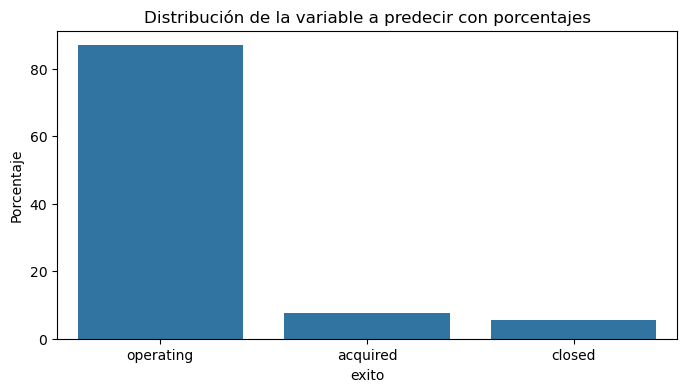

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
target = 'exito'


percentages = df[target].value_counts(normalize=True) * 100


plt.figure(figsize=(8, 4))
sns.barplot(x=percentages.index, y=percentages.values)


plt.title('Distribución de la variable a predecir con porcentajes')
plt.xlabel(target)
plt.ylabel('Porcentaje')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

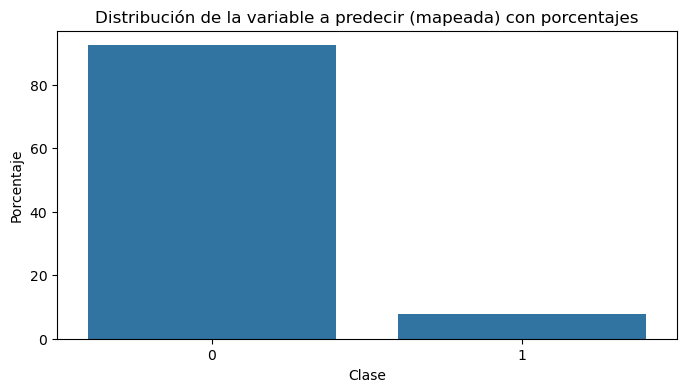

In [10]:
target = 'exito'
mapping = {'operating': 0, 'closed': 0, 'acquired': 1}
df[target] = df[target].map(mapping)

# Calcular los porcentajes de cada clase en la variable 'exito'
percentages = df[target].value_counts(normalize=True) * 100

# Crear el gráfico de barras con porcentajes
plt.figure(figsize=(8, 4))
sns.barplot(x=percentages.index, y=percentages.values)

# Configuración del gráfico
plt.title('Distribución de la variable a predecir (mapeada) con porcentajes')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')
plt.show

In [11]:
def year_group(row):
    if row['founded_year'] >= 1900 and row['founded_year'] <= 1925:
        row['founded_year_group'] = 'less_than_1925'
    elif row['founded_year'] > 1925 and row['founded_year'] <= 1950:
        row['founded_year_group'] = '1925_1950'
    elif row['founded_year'] > 1950 and row['founded_year'] <= 1975:
        row['founded_year_group'] = '1950_1975'
    elif row['founded_year'] > 1975 and row['founded_year'] <= 2000:
        row['founded_year_group'] = '1975_2000'
    elif row['founded_year'] > 2000:
        row['founded_year_group'] = '2000_2014'
    else:
        row['founded_year_group'] = ''
    return row['founded_year_group']

df['founded_year_group'] =  df.apply(year_group,axis =1)

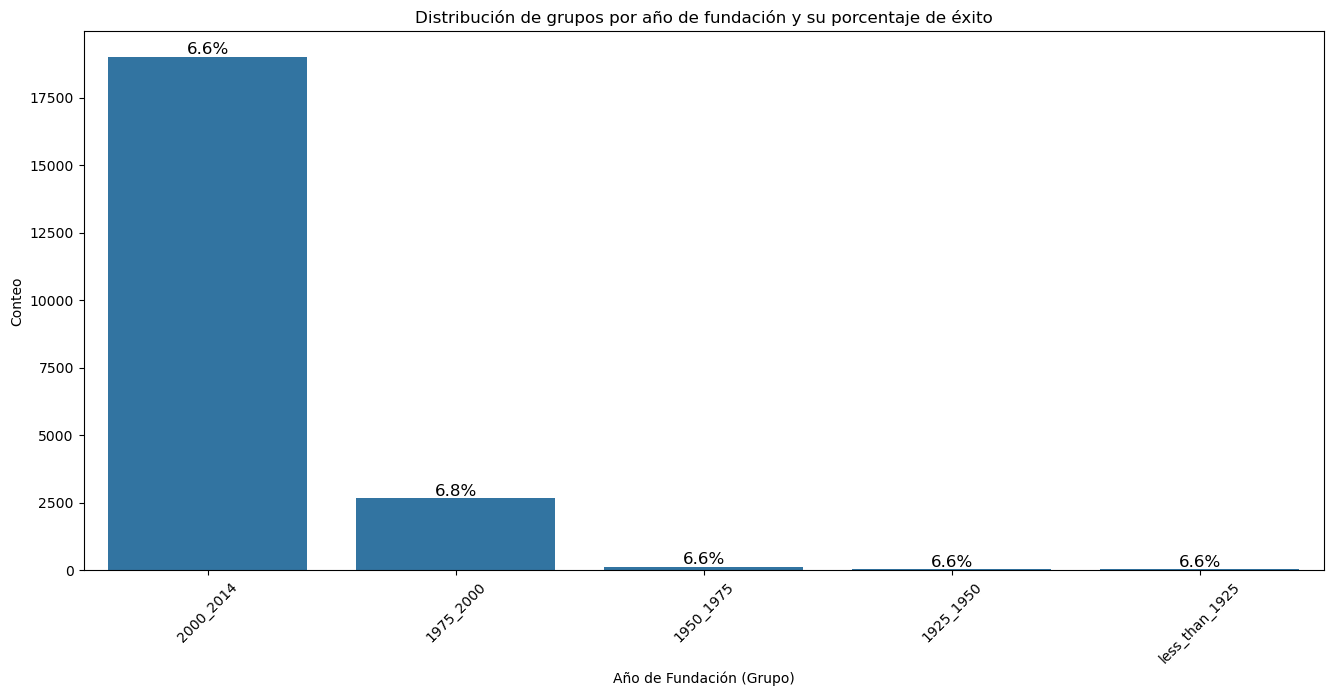

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calcular el porcentaje de 'exito = 1' para cada grupo en 'founded_year_group'
success_percentage = df.groupby('founded_year_group')['exito'].mean() * 100

# Graficar la distribución de 'founded_year_group'
plt.figure(figsize=(16, 7))

# Primero, gráfico de barras con el conteo de cada grupo
sns.countplot(x='founded_year_group', data=df.dropna())

# Añadir los porcentajes de éxito encima de las barras
for p in plt.gca().patches:
    height = p.get_height()
    # Obtener el grupo de 'founded_year_group' correspondiente (index de la barra)
    group_label = p.get_x() + p.get_width() / 2
    group_label = df['founded_year_group'].iloc[int(group_label)]  # Identificar la categoría por índice
    
    # Añadir el texto con el porcentaje de éxito en el gráfico
    plt.text(p.get_x() + p.get_width() / 2, height + 1, f'{success_percentage[group_label]:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Distribución de grupos por año de fundación y su porcentaje de éxito')
plt.xlabel('Año de Fundación (Grupo)')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()


Se puede observar que casi todas las empresas se fundan entre el año `2000` y `2014`. Por ello, ahora ploteamos la gráfica de solo los años `2000` a `2014`.

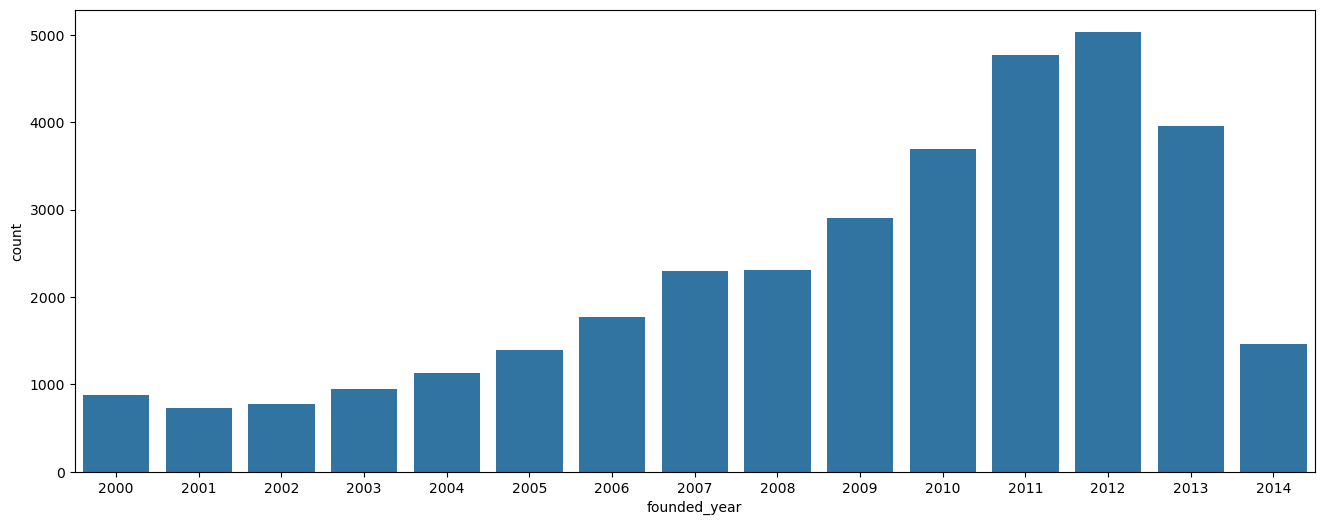

In [13]:
df_new = df[df['founded_year'] >= 2000].copy()
df_new['founded_year'] = df_new['founded_year'].astype(int)
plt.figure(figsize = (16,6))
sns.countplot(x = 'founded_year', data = df_new)
plt.show()

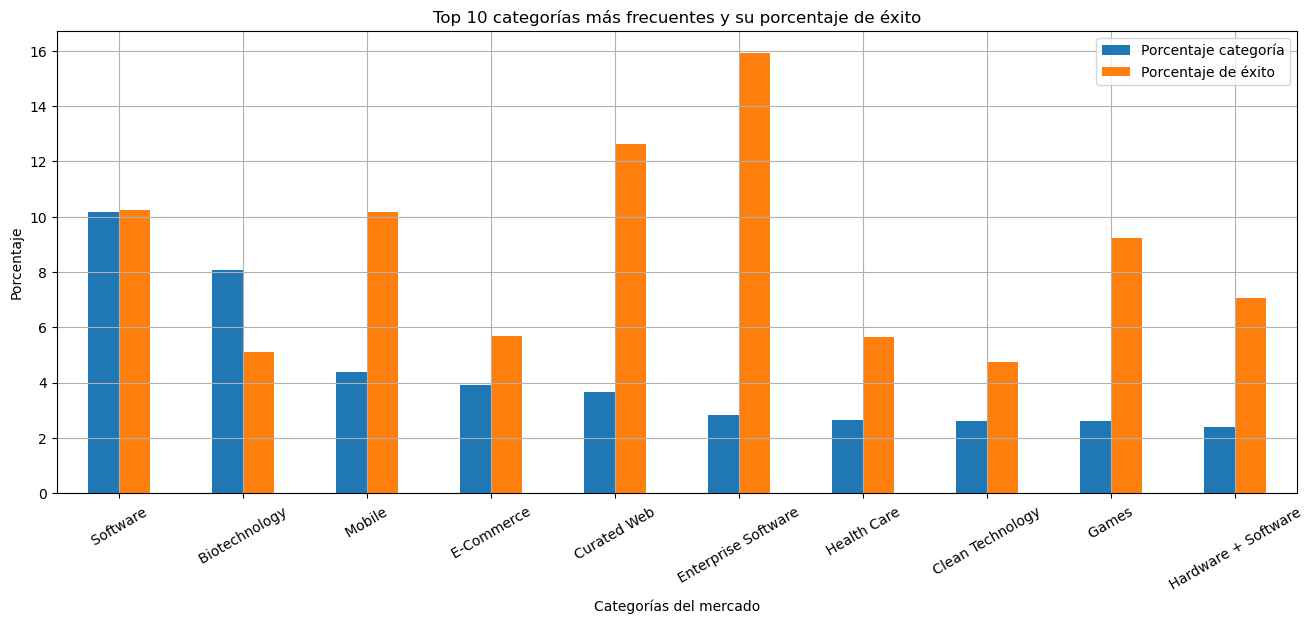

In [14]:
market_counts = df[' market '].value_counts(normalize=True) * 100

# Calcular el porcentaje de 'exito = 1' para cada categoría en 'market'
success_percentage = df.groupby(' market ')['exito'].mean() * 100

# Crear un DataFrame con los porcentajes de las categorías y el porcentaje de éxito
result_df = pd.DataFrame({
    'Porcentaje categoría': market_counts,
    'Porcentaje de éxito': success_percentage
})

# Seleccionar las 10 categorías más frecuentes
top_categories = market_counts.head(10)

# Filtrar el DataFrame resultante para mostrar solo las categorías más frecuentes
result_df_top = result_df.loc[top_categories.index]

# Graficar
result_df_top.plot(kind='bar', figsize=(16, 6))

plt.title('Top 10 categorías más frecuentes y su porcentaje de éxito')
plt.xlabel('Categorías del mercado')
plt.ylabel('Porcentaje')
plt.xticks(rotation=30)
plt.grid()
plt.show()

Se puede observar que el número de startups **aumenta** cada año.

C:\Users\samue\AppData\Local\Temp\ipykernel_13156\3066997751.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100


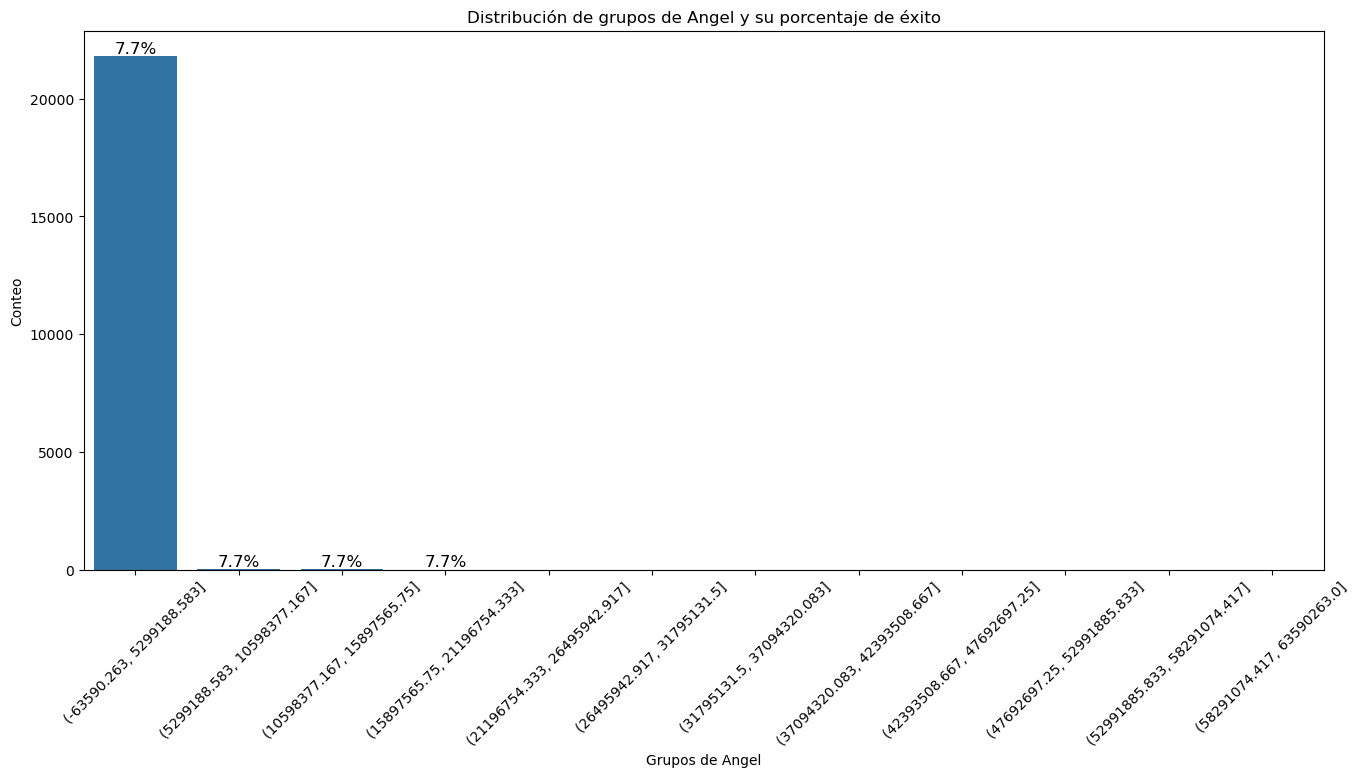

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dividir la variable 'angel' en 12 grupos utilizando pd.cut
df['angel_group'] = pd.cut(df['angel'], bins=12)

# Calcular el porcentaje de 'exito = 1' para cada grupo en 'angel_group'
success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100

# Graficar la distribución de 'angel_group'
plt.figure(figsize=(16, 7))

# Gráfico de barras con el conteo de cada grupo en 'angel_group'
sns.countplot(x='angel_group', data=df.dropna())

# Añadir los porcentajes de éxito encima de las barras
for p in plt.gca().patches:
    height = p.get_height()
    # Obtener el grupo de 'angel_group' correspondiente
    group_label = p.get_x() + p.get_width() / 2
    group_label = df['angel_group'].iloc[int(group_label)]  # Identificar la categoría por índice
    
    # Añadir el texto con el porcentaje de éxito en el gráfico
    plt.text(p.get_x() + p.get_width() / 2, height + 1, f'{success_percentage_angel_group[group_label]:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Distribución de grupos de Angel y su porcentaje de éxito')
plt.xlabel('Grupos de Angel')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()


Podemos observar que casi todas las startups son de `Software` y `Biotechnology`, seguidas de `Mobile`,`E-Commerce` y `Curated Webs`.

Realizamos un análisis de la variable a predecir en este caso, exito.

De momento vamos a asignar, la clase 1 a acquired y 0 a closed. Pero podríamos realizar otra distribución de clases si fuera de interés para el trabajo

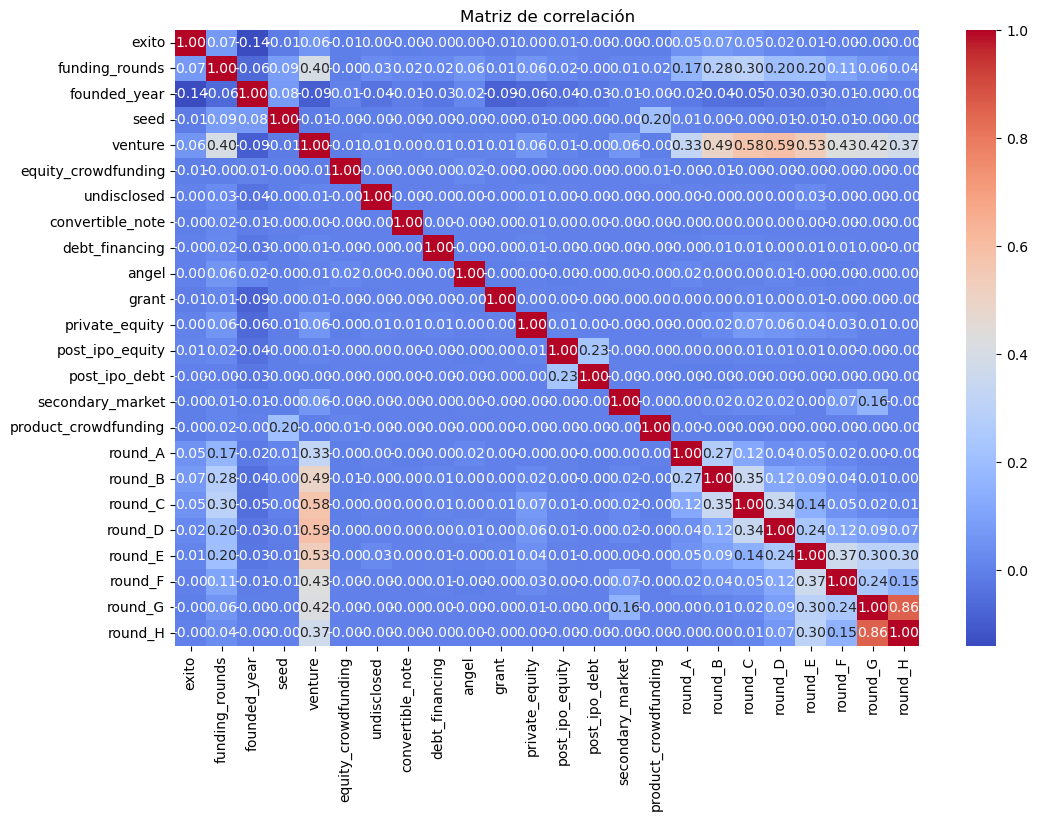

In [16]:
# Creamos una matriz de correlación entre las variables numéricas
numerical_df = df.select_dtypes(include=['number']) 
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

Text(0.5, 1.0, 'Relación entre funding_rounds, founded_year y exito')

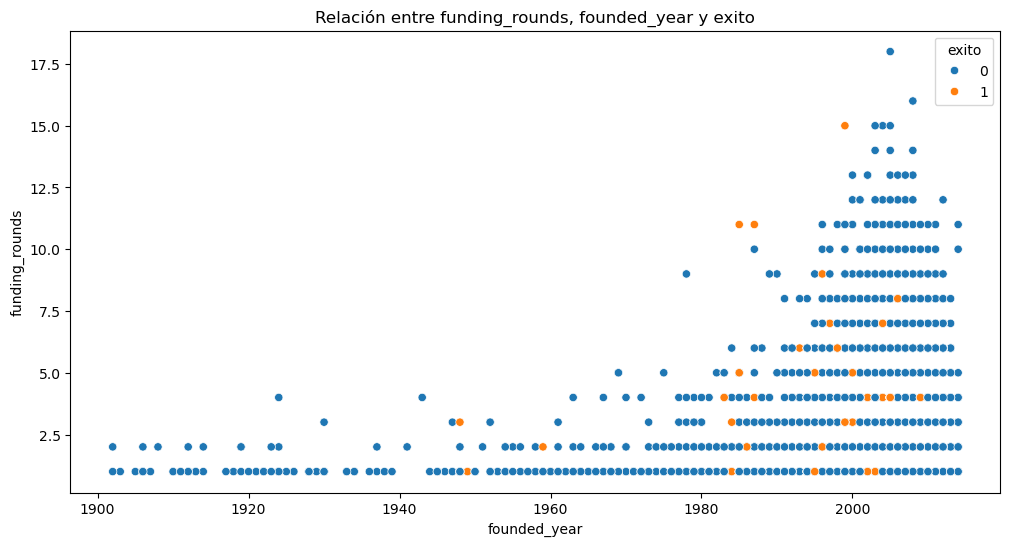

In [17]:
# Observamos que variables que están más correlacionadas con la variable de salida son funding_round y founded_year
# Observamos relacion entre funding_round, founded_year y variable objetivo 
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='founded_year', y='funding_rounds', hue='exito')
plt.title('Relación entre funding_rounds, founded_year y exito')

## 4. Preparación de los datos para clasificación simple
Para poder realizar predicciones al principio, tenemos que lidiar con valores nulos primero realizaremos un analisis sencillo y los ignoraremos o sustituiremos, posteriormente usaremos tecnicas de imputacion y similares para intentar no perder informacion relevante.

Posteriormente aplicaremos una pipeline sencilla con knn para una primera clasificacion simple del problema

In [21]:
# Creamos pipeline para eliminar valores nulos y transformar variables categóricas con knn, evaluamos modelo con la funcion evaluar_modelo
#hacer train_test_split -> 30% para test 
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier as knn_neighbors

#hacer ahora train_test_split

# Separar columnas numéricas y categóricas, excluyendo la columna objetivo 'exito'
numerical_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['exito']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Crear transformadores para columnas numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Crear pipeline completa
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn_neighbors())
])

# Convertir X y y manteniendo X como DataFrame para compatibilidad con ColumnTransformer
X = df.drop(columns=['exito'])
y = df['exito'].astype(float)  # Asegurarse de que y sea numérico

# Evaluar el pipeline
evaluar_pipeline(X, y.to_numpy(), pipeline, beta=1)

{'precision': 0.23809523809523808,
 'f_beta': 0.08830022075055188,
 'average_precision': 0.11422732238907711}